In [89]:
from unstructured.documents.elements import Table, Image

In [3]:
from dotenv import load_dotenv
import os

load_dotenv()
groq_api_key = os.getenv("GROQ_API_KEY")

In [9]:
from unstructured.partition.pdf import partition_pdf

output_path = "./data/raw/"
file_path = output_path + 'Catalogo Trox.pdf'

# Reference: https://docs.unstructured.io/open-source/core-functionality/chunking
chunks = partition_pdf(
    filename=file_path,
    infer_table_structure=True,            # extract tables
    strategy="hi_res",                     # mandatory to infer tables

    extract_image_block_types=["Image","Table"],   # Add 'Table' to list to extract image of tables
    # image_output_dir_path=output_path,   # if None, images and tables will saved in base64

    extract_image_block_to_payload=True,   # if true, will extract base64 for API usage

    chunking_strategy="basic",          # or 'basic'
    max_characters=10000,                  # defaults to 500
    combine_text_under_n_chars=2000,       # defaults to 0
    new_after_n_chars=6000,
    languages=["por","eng"],
    ocr_languages=["por","eng"]

    # extract_images_in_pdf=True,          # deprecated
)

The ocr_languages kwarg will be deprecated in a future version of unstructured. Please use languages instead.


In [13]:
# Mostra quantos elementos foram extraídos
print(f"Total de elementos extraídos: {len(chunks)}\n")

# Mostra os primeiros elementos
for i, chunk in enumerate(chunks[:5]):
    print(f"\n--- Chunk {i+1} ---")
    print(f"Tipo: {type(chunk)}")
    print(f"Texto:\n{chunk.text}")

Total de elementos extraídos: 0



In [6]:
with open("conteudo_extraido.txt", "w", encoding="utf-8") as f:
    for chunk in chunks:
        f.write(chunk.text + "\n\n")

In [ ]:
for chunk in chunks:
    print(type(chunk), "-", chunk.text[:80])

<class 'unstructured.documents.elements.CompositeElement'> - Caixas Terminais

Para filtros de alta eficiéncia, montagem no teto e montagem e
<class 'unstructured.documents.elements.CompositeElement'> - F650-A/2/E/PH2

L

|

|

Filtros com gaxeta de EPDM ou Selo Gel (Consultar medid
<class 'unstructured.documents.elements.CompositeElement'> - Dimens6es

X SSS) SS SOX SOV SQV SS SENG POR RR Geis ROR ENE ING i EA CORTE WJ D
<class 'unstructured.documents.elements.CompositeElement'> - Difusor para tamanho de filtro:

V máx = 2100 mê/h ABC GA = YV máx = 600 m°/h ——


In [4]:
# We get 2 types of elements from the partition_pdf function
set([str(type(el)) for el in chunks])

set()

In [5]:
# Each CompositeElement containes a bunch of related elements.
# This makes it easy to use these elements together in a RAG pipeline.

chunks[0].metadata.orig_elements

IndexError: list index out of range

In [ ]:
from collections import Counter

# Conta os tipos dos elementos dentro do primeiro chunk
tipo_elementos = Counter(type(el).__name__ for el in chunks[0].metadata.orig_elements)
print(tipo_elementos)

Counter({'Image': 29, 'NarrativeText': 8, 'Text': 7, 'Title': 5, 'Table': 4, 'FigureCaption': 3})


In [ ]:
# This is what an extracted image looks like.
# It contains the base64 representation only because we set the param extract_image_block_to_payload=True

elements = chunks[0].metadata.orig_elements
chunk_images = [el for el in elements if 'Image' in str(type(el))]
chunk_images[0].to_dict()

{'type': 'Image',
 'element_id': '9893d1ce-f1f4-4511-8ae0-8ee60cf2a769',
 'text': '',
 'metadata': {'detection_class_prob': 0.5340181589126587,
  'coordinates': {'points': ((np.float64(153.194091796875),
     np.float64(662.1342163085938)),
    (np.float64(153.194091796875), np.float64(1613.6915283203125)),
    (np.float64(1405.0965576171875), np.float64(1613.6915283203125)),
    (np.float64(1405.0965576171875), np.float64(662.1342163085938))),
   'system': 'PixelSpace',
   'layout_width': 1654,
   'layout_height': 2339},
  'last_modified': '2024-10-11T14:47:51',
  'filetype': 'PPM',
  'languages': ['por', 'eng'],
  'page_number': 1,
  'image_base64': '/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAO4BOQDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaE

In [ ]:
from unstructured.documents.elements import Table, Image
import base64
from PIL import Image as PILImage
from io import BytesIO
import pytesseract

def ocr_b64(b64, lang="por+eng"):
    try:
        # Se vier com prefixo data:, remove
        if b64.startswith("data:image"):
            b64 = b64.split(",", 1)[1]
        img = PILImage.open(BytesIO(base64.b64decode(b64)))
        text = pytesseract.image_to_string(img, lang=lang)
        return text.strip()
    except Exception:
        return ""

def harvest_blocks(chunks, min_text_len=10):
    texts = []           # strings de texto
    tables_html = []     # tabelas em HTML (quando houver)
    ocr_texts = []       # textos via OCR
    images_b64 = []      # imagens em base64

    for ch in chunks:
        # ---------- TABELA ----------
        if isinstance(ch, Table):
            html = getattr(getattr(ch, "metadata", None), "text_as_html", None)
            if html and len(html) > min_text_len:
                tables_html.append(html)
            else:
                # tentar OCR em imagens associadas
                origs = getattr(getattr(ch, "metadata", None), "orig_elements", None) or []
                got_ocr = False
                for el in origs:
                    if isinstance(el, Image):
                        b64 = getattr(getattr(el, "metadata", None), "image_base64", None)
                        if b64:
                            txt = ocr_b64(b64)
                            if txt:
                                ocr_texts.append(txt)
                                images_b64.append(b64)
                                got_ocr = True
                # fallback: se não rolou OCR mas há html (curto), guarda mesmo assim
                if not got_ocr and html:
                    tables_html.append(html)

        # ---------- IMAGEM PURA ----------
        elif isinstance(ch, Image):
            b64 = getattr(getattr(ch, "metadata", None), "image_base64", None)
            if b64:
                images_b64.append(b64)
                txt = ocr_b64(b64)
                if txt:
                    ocr_texts.append(txt)

        # ---------- TEXTO (qualquer elemento com .text) ----------
        elif hasattr(ch, "text"):
            t = getattr(ch, "text", "") or ""
            if len(t) >= min_text_len:
                texts.append(t)
            # varrer imagens embutidas nesse bloco
            origs = getattr(getattr(ch, "metadata", None), "orig_elements", None) or []
            for el in origs:
                if isinstance(el, Image):
                    b64 = getattr(getattr(el, "metadata", None), "image_base64", None)
                    if b64:
                        images_b64.append(b64)
                        # OCR sob demanda: se o texto do bloco for curto
                        if len(t) < min_text_len:
                            txt = ocr_b64(b64)
                            if txt:
                                ocr_texts.append(txt)

        # ---------- OUTROS TIPOS ----------
        else:
            # tenta extrair um texto “genérico”
            t = getattr(ch, "text", None) or getattr(ch, "page_content", None)
            if t and len(t) > min_text_len:
                texts.append(t)

    return {
        "texts": texts,
        "tables_html": tables_html,
        "ocr_texts": ocr_texts,
        "images_b64": images_b64,
    }


In [ ]:
elements = harvest_blocks(chunks)

texts       = elements["texts"]              # lista de strings
tables      = elements["tables_html"]             # lista de dicts {"text":..., "html":...}
ocr_texts   = elements['ocr_texts']
images_b64  = elements["images_b64"]         # lista de base64
print(len(texts), len(tables),len(ocr_texts), len(images_b64))

10 0 0 641


In [ ]:
from unstructured.documents.elements import Table, Image

tables, texts, images = [], [], []

for ch in chunks:
    # Tabela “pura”
    if isinstance(ch, Table):
        tables.append(ch)

    # Tabelas aninhadas
    if hasattr(ch.metadata, "orig_elements") and ch.metadata.orig_elements:
        for el in ch.metadata.orig_elements:
            if isinstance(el, Table):
                tables.append(el)
            if isinstance(el, Image) and getattr(el.metadata, "image_base64", None):
                images.append(el.metadata.image_base64)

    # Texto
    if "CompositeElement" in str(type(ch)):
        texts.append(ch)

In [ ]:
tables

In [ ]:
# separate tables from texts
tables = []
texts = []

for chunk in chunks:
    if "Table" in str(type(chunk)):
        tables.append(chunk)

    if "CompositeElement" in str(type((chunk))):
        texts.append(chunk)

In [ ]:
print(type(chunks[1]))

<class 'unstructured.documents.elements.CompositeElement'>


In [ ]:
print(tables)

[]


In [ ]:
# Get the images from the CompositeElement objects
def get_images_base64(chunks):
    images_b64 = []
    for chunk in chunks:
        if "CompositeElement" in str(type(chunk)):
            chunk_els = chunk.metadata.orig_elements
            for el in chunk_els:
                if "Image" in str(type(el)):
                    images_b64.append(el.metadata.image_base64)
    return images_b64

images = get_images_base64(chunks)

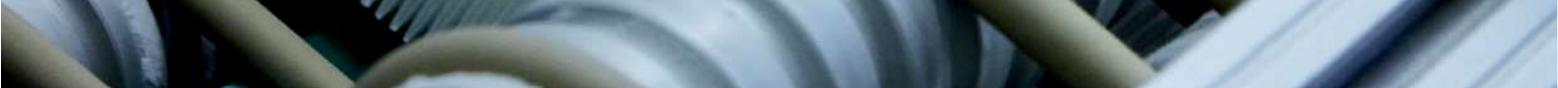

In [ ]:
import base64
from IPython.display import Image, display

def display_base64_image(base64_code):
    # Decode the base64 string to binary
    image_data = base64.b64decode(base64_code)
    # Display the image
    display(Image(data=image_data))

display_base64_image(images[12])

In [ ]:
from langchain_groq import ChatGroq
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

In [ ]:
# Prompt
prompt_text = """
You are an assistant. If the input is a question, answer it clearly and concisely.
If the input is a piece of text or table, summarize it.

Input:
{element}
"""
prompt = ChatPromptTemplate.from_template(prompt_text)

# Summary chain
model = ChatGroq(api_key=groq_api_key,temperature=0.5, model="llama-3.1-8b-instant")
summarize_chain = {"element": lambda x: x} | prompt | model | StrOutputParser()

In [ ]:
import time
from langchain_core.runnables import Runnable
from typing import List

def safe_batch_process(chain: Runnable, data: List[str], batch_size=1, wait_on_error=10):
    results = []
    for i in range(0, len(data), batch_size):
        batch = data[i:i+batch_size]
        try:
            batch_results = chain.batch(batch, {"max_concurrency": 2})
            results.extend(batch_results)
        except Exception as e:
            print(f"⏱️ Rate limit atingido ou erro: {e}")
            print(f"🔁 Esperando {wait_on_error} segundos para tentar de novo...")
            time.sleep(wait_on_error)
            # tenta o mesmo batch de novo
            try:
                batch_results = chain.batch(batch, {"max_concurrency": 2})
                results.extend(batch_results)
            except Exception as e2:
                print(f"❌ Ainda deu erro: {e2} — pulando esse batch.")
    return results


In [ ]:
text_summaries = safe_batch_process(summarize_chain, texts)

In [ ]:
text_summaries

['Aqui está uma análise do texto fornecido:\n\nA empresa TROX é uma referência no mercado de filtragem e controle de contaminação em sistemas de tratamento de ar. Ela possui uma linha completa de filtros antimicrobianos, grossos, médios, finos, absolutos e carvão ativado para sistemas de ventilação e climatização. A empresa conta com uma equipe técnica especializada em soluções de filtragem para proporcionar bem-estar as pessoas, proteção ao meio ambiente e processos.\n\nA TROX testa seus filtros em conformidade com os padrões internacionais e atende às mais rigorosas exigências de higiene. Ela realiza testes de eficiência dos filtros de acordo com as normativas EN779 ou EN1822, dependendo do tipo de filtro.\n\nA empresa também menciona a nova norma ISO 16890, que visa melhorar os padrões de qualidade do ar. A norma divide as faixas de partículas em PM10, PM2,5 e PM1, permitindo relacionar a eficiência de filtragem com os efeitos das partículas na saúde humana.\n\nA classificação de fi

In [ ]:
table_summaries = safe_batch_process(summarize_chain, tables)

In [ ]:
table_summaries

[]

In [ ]:
from PIL import Image
from io import BytesIO
import base64
import pytesseract

def ocr_from_images_base64(images_b64):
    image_texts = []
    for b64 in images_b64:
        try:
            image_data = base64.b64decode(b64)
            image = Image.open(BytesIO(image_data))
            text = pytesseract.image_to_string(image, lang="por+eng")
            image_texts.append(text)
        except Exception as e:
            print(f"❌ Erro ao processar imagem: {e}")
    return image_texts

ocr_texts = ocr_from_images_base64(images)

❌ Erro ao processar imagem: argument should be a bytes-like object or ASCII string, not 'NoneType'
❌ Erro ao processar imagem: argument should be a bytes-like object or ASCII string, not 'NoneType'
❌ Erro ao processar imagem: argument should be a bytes-like object or ASCII string, not 'NoneType'
❌ Erro ao processar imagem: argument should be a bytes-like object or ASCII string, not 'NoneType'
❌ Erro ao processar imagem: argument should be a bytes-like object or ASCII string, not 'NoneType'
❌ Erro ao processar imagem: argument should be a bytes-like object or ASCII string, not 'NoneType'
❌ Erro ao processar imagem: argument should be a bytes-like object or ASCII string, not 'NoneType'
❌ Erro ao processar imagem: argument should be a bytes-like object or ASCII string, not 'NoneType'
❌ Erro ao processar imagem: argument should be a bytes-like object or ASCII string, not 'NoneType'
❌ Erro ao processar imagem: argument should be a bytes-like object or ASCII string, not 'NoneType'
❌ Erro ao 

In [ ]:
# Prompt com variável {element}
prompt_text_image = """
The following is OCR-extracted text from an image found in a technical document.

Describe in detail what the image is likely showing, based on the text.
Be specific about diagrams, graphs, or bar plots if relevant.

OCR text:
{element}
"""

prompt_image = ChatPromptTemplate.from_template(prompt_text_image)

# Agora sim, o chain está coerente
summarize_chain = {"element": lambda x: x} | prompt_image | model | StrOutputParser()

In [ ]:
image_summaries = safe_batch_process(summarize_chain, ocr_texts)

In [ ]:
image_summaries

["However, you haven't provided the OCR-extracted text from the image. Please paste the text, and I'll do my best to describe what the image is likely showing based on the content.",
 "Unfortunately, you haven't provided the OCR-extracted text yet. Please paste the text, and I'll do my best to describe what the image is likely showing.",
 "However, it seems you haven't provided the OCR-extracted text from the image. Please go ahead and share the text, and I'll do my best to describe the likely image content based on the text.",
 "However, it seems you haven't provided the OCR-extracted text from the image. Please paste the text, and I'll do my best to describe the image based on the information provided.",
 "However, you haven't provided the OCR-extracted text from the image. Please share the text, and I'll do my best to describe what the image is likely showing, based on the content and any relevant diagrams, graphs, or bar plots.",
 "I'm ready to help, but you haven't provided the OC

In [ ]:
import uuid
from langchain.vectorstores import Chroma
from langchain.storage import InMemoryStore
from langchain.schema.document import Document
from langchain.embeddings import OpenAIEmbeddings
from langchain.retrievers.multi_vector import MultiVectorRetriever
from langchain.embeddings import HuggingFaceEmbeddings

embedding_function = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")
vectorstore = Chroma(collection_name="multi_modal_rag", embedding_function=embedding_function)

# The storage layer for the parent documents
store = InMemoryStore()
id_key = "doc_id"

# The retriever (empty to start)
retriever = MultiVectorRetriever(
    vectorstore=vectorstore,
    docstore=store,
    id_key=id_key,
)

In [ ]:
# Add texts
doc_ids = [str(uuid.uuid4()) for _ in texts]
summary_texts = [
    Document(page_content=summary, metadata={id_key: doc_ids[i]}) for i, summary in enumerate(text_summaries)
]
retriever.vectorstore.add_documents(summary_texts)
retriever.docstore.mset(list(zip(doc_ids, texts))),

# Add tables
table_ids = [str(uuid.uuid4()) for _ in tables]
summary_tables = [
    Document(page_content=summary, metadata={id_key: table_ids[i]}) for i, summary in enumerate(table_summaries)]
#retriever.vectorstore.add_documents(summary_tables)
retriever.docstore.mset(list(zip(table_ids, tables)))

# Add image summaries
img_ids = [str(uuid.uuid4()) for _ in images]
summary_img = [
    Document(page_content=summary, metadata={id_key: img_ids[i]}) for i, summary in enumerate(image_summaries)
]
retriever.vectorstore.add_documents(summary_img)
retriever.docstore.mset(list(zip(img_ids, images)))

In [ ]:
# Retrieve
docs = retriever.invoke(
    "who are the authors of the paper?"
)
print(docs)

['/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAACAAIDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwDEVFCABQABwAKKKKzOI//Z', '/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIR

In [ ]:
for doc in docs:
    print(str(doc) + "\n\n" + "-" * 80)

1 170 (600) 2 255 (900) 3 340 (1200) 4 406 (1445) 5 212 (745) 535 x 535 x 78 835 x 535 x 78 600 1135 x 535 x 78 600 1220 x 610 x 78 675 610 x 610 x 78 675 900 313 549 849 1200 348 549 1149 1285 348 624 1234 675 398 624 624

--------------------------------------------------------------------------------


In [ ]:
from langchain_core.runnables import RunnablePassthrough, RunnableLambda
from langchain_core.output_parsers import StrOutputParser
from langchain_groq import ChatGroq
from base64 import b64decode
import os

# LLM - Groq com LLaMA 3
model = ChatGroq(
    api_key=os.getenv("GROQ_API_KEY"),
    model="llama-3.1-8b-instant",
    temperature=0.2
)

# Separa textos e imagens, mas ignora imagens no processamento
def parse_docs(docs):
    b64 = []
    text = []
    for doc in docs:
        try:
            b64decode(doc)
            b64.append(doc)  # ← será ignorado, mas salvo se quiser usar depois
        except Exception:
            text.append(doc)
    return {"images": b64, "texts": text}

# Monta prompt apenas com texto extraído
def build_prompt(kwargs):
    docs_by_type = kwargs["context"]
    user_question = kwargs["question"]

    context_text = ""
    if len(docs_by_type["texts"]) > 0:
        for text_element in docs_by_type["texts"]:
            context_text += text_element.text + "\n\n"

    prompt_template = f"""
Você é um assistente técnico. Responda com base apenas no seguinte contexto (extraído de documentos PDF e imagens convertidas para texto):

{context_text}

Pergunta: {user_question}
Resposta:
    """

    return prompt_template.strip()

# Chain simples
chain = (
    {
        "context": retriever | RunnableLambda(parse_docs),
        "question": RunnablePassthrough(),
    }
    | RunnableLambda(build_prompt)
    | model
    | StrOutputParser()
)

# Chain com fontes (retorna também o contexto usado)
chain_with_sources = {
    "context": retriever | RunnableLambda(parse_docs),
    "question": RunnablePassthrough(),
} | RunnablePassthrough().assign(
    response=(
        RunnableLambda(build_prompt)
        | model
        | StrOutputParser()
    )
)


In [ ]:
response = chain.invoke(
    "Qual é a tecnologia antimicrobiana?"
)

print(response)

Infelizmente, a tecnologia antimicrobiana não é mencionada explicitamente no texto fornecido. No entanto, podemos inferir que a TROX oferece filtros antimicrobianos, que são projetados para controlar a contaminação e proteger o bem-estar das pessoas. É provável que a tecnologia antimicrobiana utilizada seja uma tecnologia de tratamento de superfície ou de material que inibe o crescimento de bactérias, vírus e outros microrganismos.

No entanto, para uma resposta mais precisa, seria necessário consultar o catálogo ou a documentação técnica da TROX para obter informações sobre a tecnologia antimicrobiana específica utilizada em seus filtros.


In [ ]:
response = chain_with_sources.invoke(
    "Quais são as características do filtro médio M5 F74B?"
)

print("Response:", response['response'])

print("\n\nContext:")
for text in response['context']['texts']:
    print(text.text)
    print("Page number: ", text.metadata.page_number)
    print("\n" + "-"*50 + "\n")
for image in response['context']['images']:
    display_base64_image(image)

Response: Infelizmente, não há informações sobre o filtro médio M5 F74B no texto fornecido. No entanto, posso ajudar a identificar as características dos filtros que estão disponíveis no texto.

Os filtros mencionados no texto são:

- F70B 30 / MANTA # 50 / 1200 x 2000 (filtro grosso G3)
- F71B 20/4 / MANTA # 18 / 00 / 1200 x 2000 (filtro médio G4)

Se você estiver procurando por informações sobre o filtro médio M5 F74B, é provável que ele não esteja listado no texto fornecido. Se você tiver mais informações sobre o filtro M5 F74B, posso tentar ajudar a identificar suas características.


Context:
Codificação do filtro

F70B 30 / MANTA # 50 / 1200 x 2000

| 1

| 2

| 3

| 4

1) Grau de Filtragem: 30=G3

2) Construgao: ENCP - Encartonado Plano MANTA - Cortada ou Rolo F100 - Cassete

3] Espessura Nominal: 24 =24mm 48 = 48mm 50 = 50mm

4) Tamanho Nominal [mm]: Base [B] x Altura [H] Maximos e Minimos conforme tabela

G4

Grosso

Características do Produto:

m Meio filtrante em fibras sinté